In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import missingno as mno
import plotly.offline as pyo
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix

In [132]:
df = pd.read_csv('/content/drive/MyDrive/ds_salaries.csv')
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


#**Data analysis**

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [134]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
work_year,3755.0,2022.373635,0.691448,2020.0,2022.0,2022.0,2023.0,2023.0
salary,3755.0,190695.571771,671676.500508,6000.0,100000.0,138000.0,180000.0,30400000.0
salary_in_usd,3755.0,137570.389880,63055.625278,5132.0,95000.0,135000.0,175000.0,450000.0
remote_ratio,3755.0,46.271638,48.589050,0.0,0.0,0.0,100.0,100.0


In [135]:
df.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [136]:
unique_values = df.nunique()
unique_values

work_year                4
experience_level         4
employment_type          4
job_title               93
salary                 815
salary_currency         20
salary_in_usd         1035
employee_residence      78
remote_ratio             3
company_location        72
company_size             3
dtype: int64

In [137]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (12, 8)})
        sns.heatmap(corr, cmap="RdBu", annot=True, fmt=".2f")  # annot=True added here
        plt.show()
    return drop_list

<ipython-input-137-ae336b5f743c>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

<ipython-input-137-ae336b5f743c>:4: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



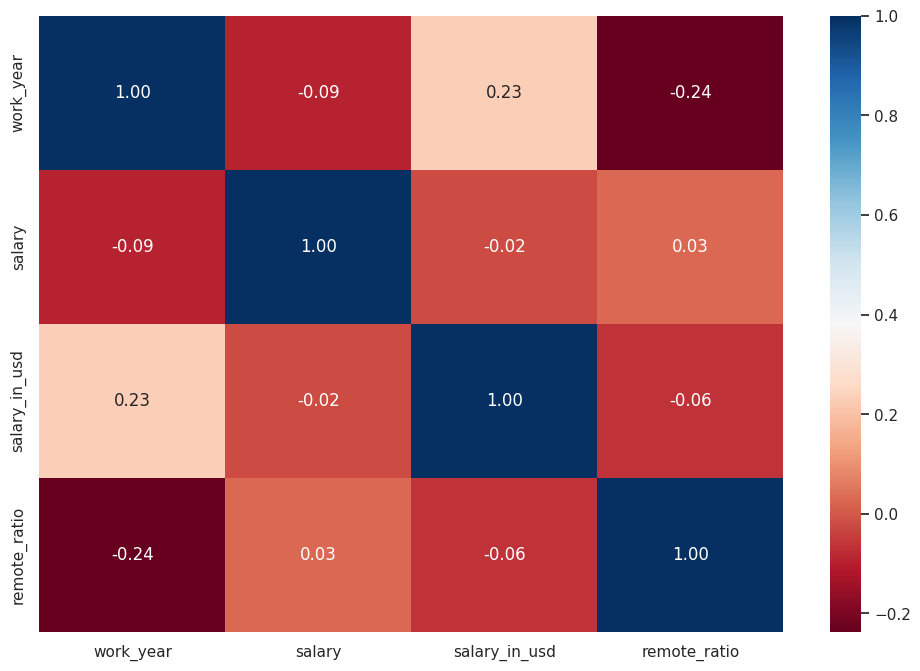

[]

In [138]:
high_correlated_cols(df, plot=True)

array([[<Axes: title={'center': 'work_year'}>,
        <Axes: title={'center': 'salary'}>],
       [<Axes: title={'center': 'salary_in_usd'}>,
        <Axes: title={'center': 'remote_ratio'}>]], dtype=object)

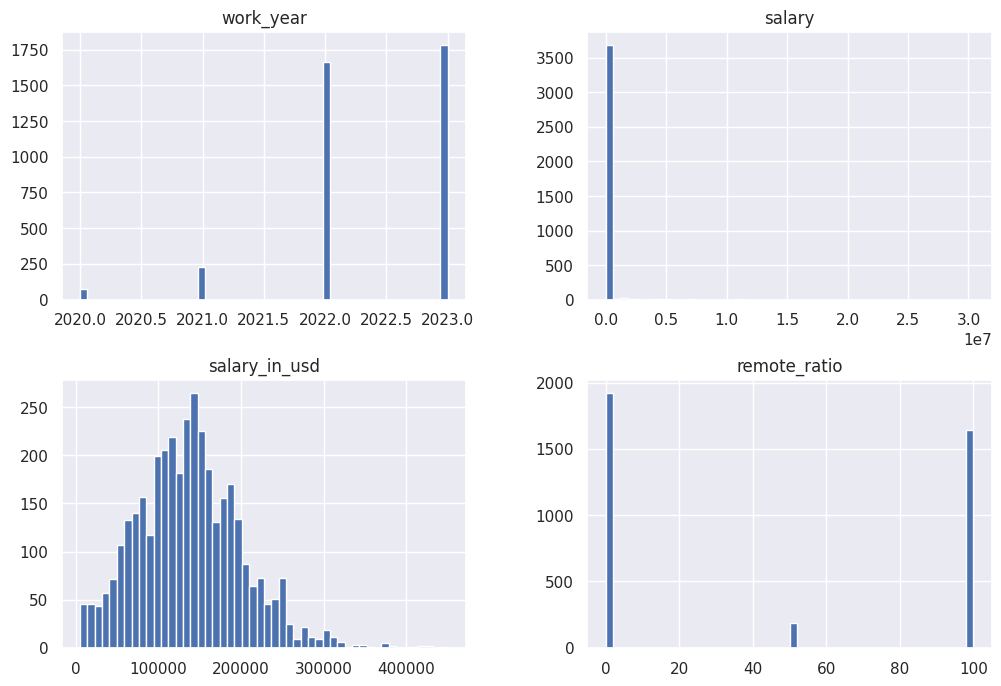

In [139]:
df.hist(bins=50)

In [140]:
trends = df.groupby('job_title')['salary_in_usd'].sum().reset_index()

fig_monthly_trends = px.line(
    trends,
    x='job_title',
    y='salary_in_usd',
    labels={'job_title': 'Job', 'salary_in_usd': 'Salary [USD]'},
    title='Salary having regard Job',
    height=600
)

fig_monthly_trends.show()

In [141]:
trends = df.groupby('employee_residence')['salary_in_usd'].sum().reset_index()

fig_monthly_trends = px.line(
    trends,
    x='employee_residence',
    y='salary_in_usd',
    labels={'employee_residence': 'Residence', 'salary_in_usd': 'Salary [USD]'},
    title='Salary having regard employee residence',
    height=600
)

fig_monthly_trends.show()

In [142]:
trends = df.groupby('company_location')['salary_in_usd'].sum().reset_index()

fig_monthly_trends = px.line(
    trends,
    x='company_location',
    y='salary_in_usd',
    labels={'company_location': 'Location', 'salary_in_usd': 'Salary [USD]'},
    title='Salary having regard company location'
)

fig_monthly_trends.show()

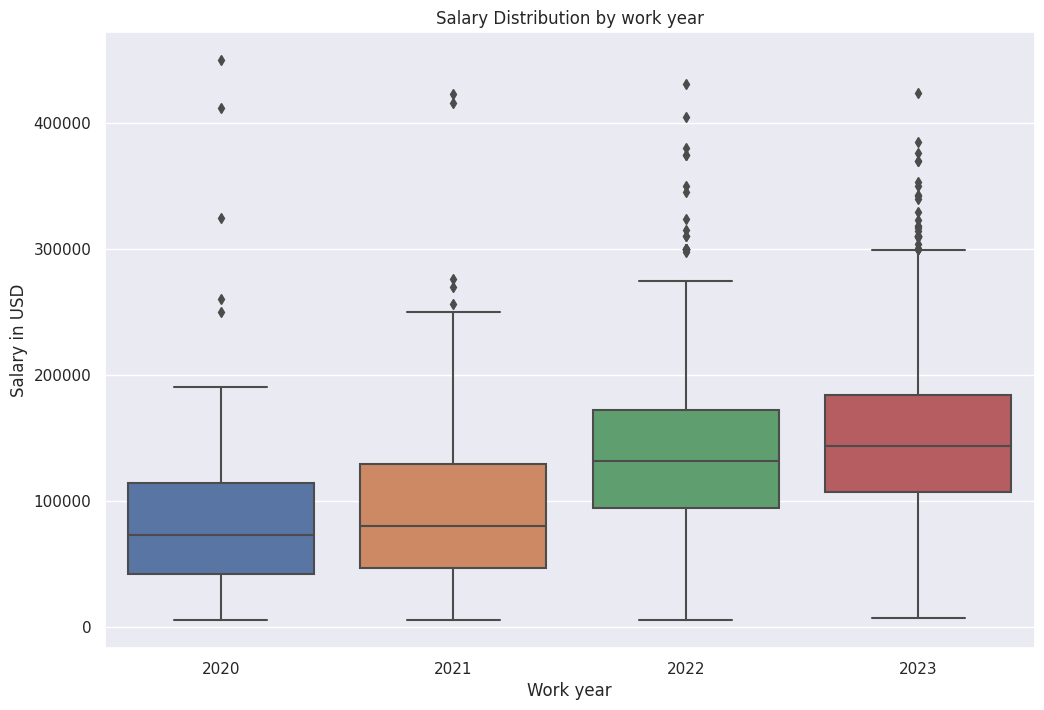

In [143]:
sns.boxplot(x='work_year', y='salary_in_usd', data=df)
plt.xlabel('Work year')
plt.ylabel('Salary in USD')
plt.title('Salary Distribution by work year')
plt.show()

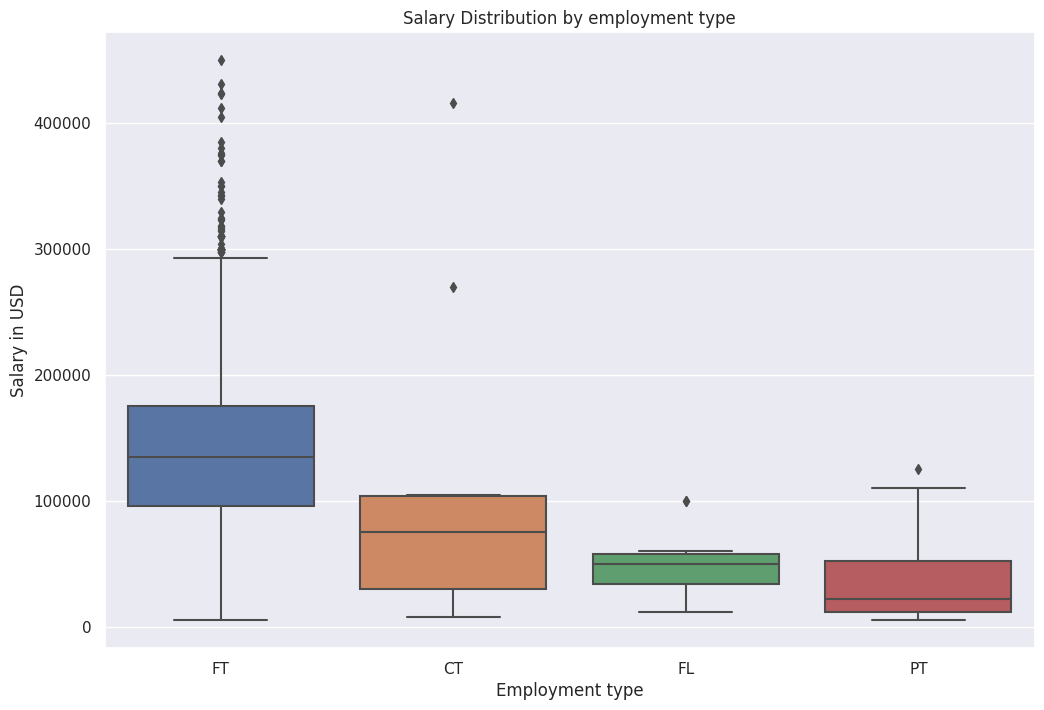

In [144]:
sns.boxplot(x='employment_type', y='salary_in_usd', data=df)
plt.xlabel('Employment type')
plt.ylabel('Salary in USD')
plt.title('Salary Distribution by employment type')
plt.show()

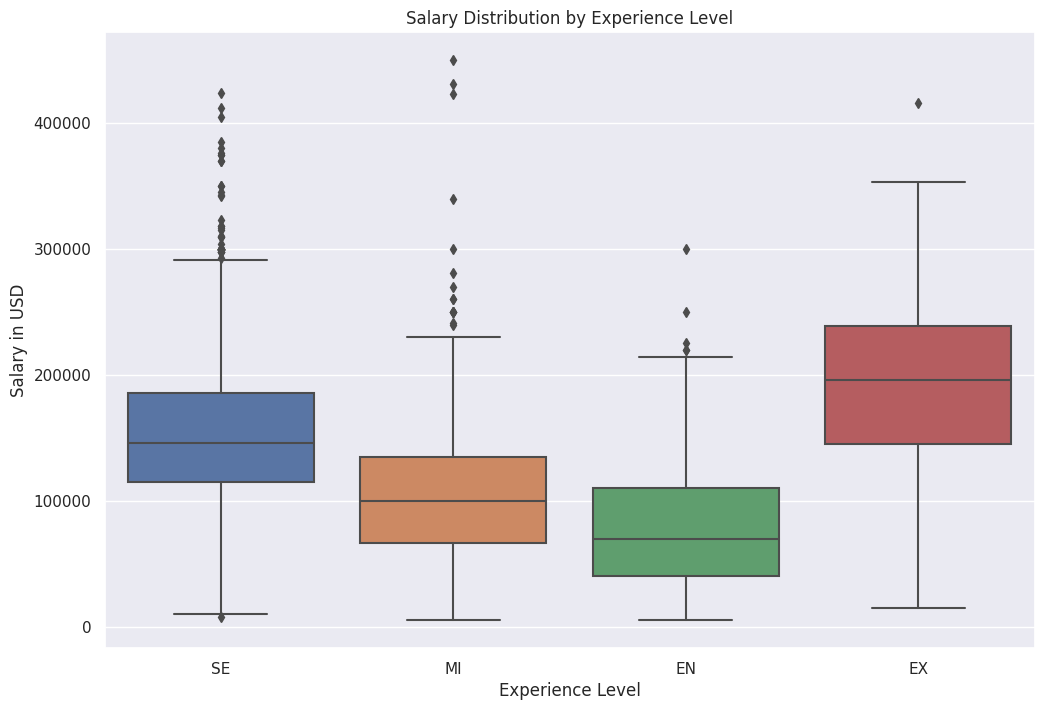

In [145]:
sns.boxplot(x='experience_level', y='salary_in_usd', data=df)
plt.xlabel('Experience Level')
plt.ylabel('Salary in USD')
plt.title('Salary Distribution by Experience Level')
plt.show()

Text(0.5, 1.0, 'Distribution of Salary')

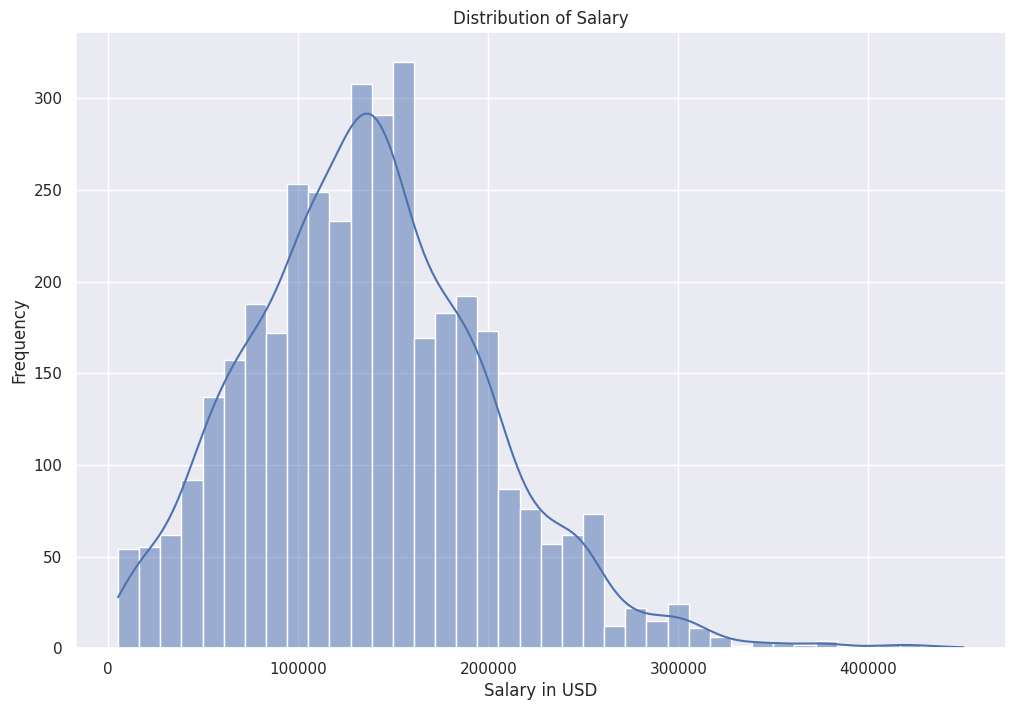

In [146]:
data = df['salary_in_usd']
sns.histplot(data, kde=True, bins=40)
plt.xlabel('Salary in USD')
plt.ylabel('Frequency')
plt.title('Distribution of Salary')

#**Data engineering**

In [147]:
df_dummy = pd.get_dummies(df, columns=['experience_level','employment_type','company_size'])
df_dummy

,work_year,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,company_size_L,company_size_M,company_size_S
0,2023,Principal Data Scientist,80000,EUR,85847,ES,100,ES,0,0,0,1,0,0,1,0,1,0,0
1,2023,ML Engineer,30000,USD,30000,US,100,US,0,0,1,0,1,0,0,0,0,0,1
2,2023,ML Engineer,25500,USD,25500,US,100,US,0,0,1,0,1,0,0,0,0,0,1
3,2023,Data Scientist,175000,USD,175000,CA,100,CA,0,0,0,1,0,0,1,0,0,1,0
4,2023,Data Scientist,120000,USD,120000,CA,100,CA,0,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,Data Scientist,412000,USD,412000,US,100,US,0,0,0,1,0,0,1,0,1,0,0
3751,2021,Principal Data Scientist,151000,USD,151000,US,100,US,0,0,1,0,0,0,1,0,1,0,0
3752,2020,Data Scientist,105000,USD,105000,US,100,US,1,0,0,0,0,0,1,0,0,0,1
3753,2020,Business Data Analyst,100000,USD,100000,US,100,US,1,0,0,0,1,0,0,0,1,0,0


In [148]:
df_dummy['remote_ratio'] = df_dummy['remote_ratio'].replace({100: 3, 50: 2, 0: 1})
df_dummy = df_dummy.drop(columns = ['salary_currency'])
df_dummy

,work_year,job_title,salary,salary_in_usd,employee_residence,remote_ratio,company_location,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,company_size_L,company_size_M,company_size_S
0,2023,Principal Data Scientist,80000,85847,ES,3,ES,0,0,0,1,0,0,1,0,1,0,0
1,2023,ML Engineer,30000,30000,US,3,US,0,0,1,0,1,0,0,0,0,0,1
2,2023,ML Engineer,25500,25500,US,3,US,0,0,1,0,1,0,0,0,0,0,1
3,2023,Data Scientist,175000,175000,CA,3,CA,0,0,0,1,0,0,1,0,0,1,0
4,2023,Data Scientist,120000,120000,CA,3,CA,0,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,Data Scientist,412000,412000,US,3,US,0,0,0,1,0,0,1,0,1,0,0
3751,2021,Principal Data Scientist,151000,151000,US,3,US,0,0,1,0,0,0,1,0,1,0,0
3752,2020,Data Scientist,105000,105000,US,3,US,1,0,0,0,0,0,1,0,0,0,1
3753,2020,Business Data Analyst,100000,100000,US,3,US,1,0,0,0,1,0,0,0,1,0,0


In [149]:
df_dummy.info()
print(df_dummy.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   work_year            3755 non-null   int64 
 1   job_title            3755 non-null   object
 2   salary               3755 non-null   int64 
 3   salary_in_usd        3755 non-null   int64 
 4   employee_residence   3755 non-null   object
 5   remote_ratio         3755 non-null   int64 
 6   company_location     3755 non-null   object
 7   experience_level_EN  3755 non-null   uint8 
 8   experience_level_EX  3755 non-null   uint8 
 9   experience_level_MI  3755 non-null   uint8 
 10  experience_level_SE  3755 non-null   uint8 
 11  employment_type_CT   3755 non-null   uint8 
 12  employment_type_FL   3755 non-null   uint8 
 13  employment_type_FT   3755 non-null   uint8 
 14  employment_type_PT   3755 non-null   uint8 
 15  company_size_L       3755 non-null   uint8 
 16  compan

In [150]:
def one_hot_encoder(df, categorical_cols, drop_first=True):
  df = pd.get_dummies(df, columns=categorical_cols, drop_first=drop_first)
  return df

objects = df_dummy.select_dtypes(include="object").columns
cols = [col for col in df_dummy.columns if 10 >= df_dummy[col].nunique() > 4]

df_dummy = one_hot_encoder(df_dummy, objects)

df_dummy.head()

,work_year,salary,salary_in_usd,remote_ratio,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_CT,employment_type_FL,...,company_location_RU,company_location_SE,company_location_SG,company_location_SI,company_location_SK,company_location_TH,company_location_TR,company_location_UA,company_location_US,company_location_VN
0,2023,80000,85847,3,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2023,30000,30000,3,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,2023,25500,25500,3,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,2023,175000,175000,3,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2023,120000,120000,3,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#**Data prediction**

In [151]:
X = df_dummy.drop(columns = ['salary', 'salary_in_usd', ]).dropna()
Y = df_dummy['salary_in_usd']
columns = X.columns

In [152]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
Y = np.log(Y)

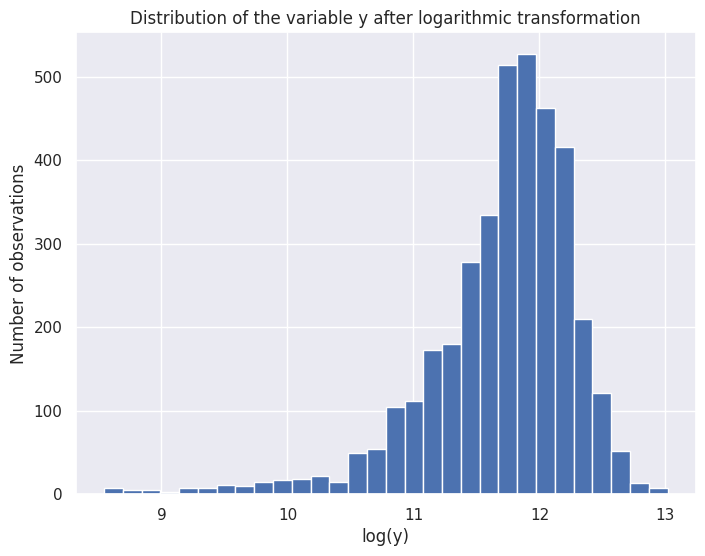

In [153]:
plt.figure(figsize=(8, 6))
plt.hist(Y, bins=30)
plt.title('Distribution of the variable y after logarithmic transformation')
plt.xlabel('log(y)')
plt.ylabel('Number of observations')
plt.show()

In [154]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(3004, 253) (751, 253) (3004,) (751,)


In [155]:
class Regressor:
  results = {'Model_name':[], 'R2':[], 'MSE': [], 'MAE': []}

  def __init__(self, X_train, Y_train, X_test, Y_test):
    self.X_train = X_train
    self.X_test = X_test
    self.Y_train = Y_train
    self.Y_test = Y_test
    self.model = None
    self.model_customized = None
    self.param_grid = None

  def grid_combination(self):
    total_params = 1
    for par in self.param_grid:
        total_params  = total_params * len(self.param_grid[par])
    return total_params

  def run_param_random_search(self):
    print('Total parameters', self.grid_combination())
    random_search = RandomizedSearchCV(self.model, param_distributions=self.param_grid, cv=4, n_iter=30, verbose=0, random_state=42)
    random_search.fit(self.X_train, self.Y_train)
    print('Random search best result:', random_search.best_estimator_)

  def run_param_grid_search(self):
    print('Total parameters', self.grid_combination())
    grid_search = GridSearchCV(self.model, param_grid=self.param_grid, cv=5,verbose=0)
    grid_search.fit(self.X_train, self.Y_train)
    print('Grid search best result:', grid_search.best_params_)

  def run_model(self, name = None):
    model = self.model_customized
    model.fit(self.X_train, self.Y_train)
    predict = model.predict(self.X_test)

    print('The result on the test set r2:', r2_score(self.Y_test, predict))
    print('The result on the test set MSE:', mean_squared_error(self.Y_test, predict))
    print('The result on the test set MAE:', mean_absolute_error(self.Y_test, predict))

    if name:
      Regressor.results['Model_name'].append(name)
      Regressor.results['R2'].append(r2_score(self.Y_test, predict))
      Regressor.results['MSE'].append(mean_squared_error(self.Y_test, predict))
      Regressor.results['MAE'].append(mean_absolute_error(self.Y_test, predict))

    self.model_customized = model
    return model

  def customize_model(self):
    pass

  def plot_PCA(self):
    plt.figure(figsize=(15, 8))
    pca = PCA()
    pca.fit(self.X_train)
    plt.bar(range(pca.n_components_),pca.explained_variance_ratio_)
    plt.show()
    pass

  def plot_importance(self, number = 10):
    feature_imp = pd.DataFrame({"Value": self.model_customized.feature_importances_, "Feature": columns})
    plt.figure(figsize=(10, 4))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:number])
    plt.title("Features")
    plt.tight_layout()
    plt.show()

  def customize_x(self, n_pca_comp = 25):
    pca = PCA()
    pca.fit(self.X_train)
    X_pca_train = pca.transform(X_train)[:,:n_pca_comp+1]
    X_pca_test = pca.transform(X_test)[:,:n_pca_comp+1]

    self.X_train = X_pca_train
    self.X_test = X_pca_test


In [156]:
class RandomForest(Regressor):
  def __init__(self, X_train, Y_train, X_test, Y_test):
    super().__init__(X_train, Y_train, X_test, Y_test)
    self.param_grid = {"max_depth": [2,5,8, 10, None], "n_estimators":[5,10,20,30,50],"min_samples_leaf":[2,4,8,20]}
    self.model = RandomForestRegressor(random_state=42)

  def customize_model(self, n_estimators = 50, min_samples_leaf= 8, max_depth = None):
    self.model_customized = RandomForestRegressor(n_estimators = n_estimators, min_samples_leaf=min_samples_leaf, max_depth = max_depth, random_state=42)

class XGBoost(Regressor):
  def __init__(self, X_train, Y_train, X_test, Y_test):
    super().__init__(X_train, Y_train, X_test, Y_test)
    self.param_grid = {"max_depth": [2,5,8, 10, None], "n_estimators":[10,20,50,100], "learning_rate":[0.001, 0.01, 0.005, 0.1]}
    self.model = XGBRegressor(random_state=42)

  def customize_model(self, max_depth = None, n_estimators= 50, learning_rate = 0.1):
    self.model_customized = XGBRegressor(max_depth = max_depth, n_estimators = n_estimators, learning_rate=learning_rate, random_state=42)

class Linear(Regressor):
  def __init__(self, X_train, Y_train, X_test, Y_test):
    super().__init__(X_train, Y_train, X_test, Y_test)
    self.param_grid = None
    self.model = LinearRegression()
    self.model_customized = self.model

class SVRModel(Regressor):
  def __init__(self, X_train, Y_train, X_test, Y_test):
    super().__init__(X_train, Y_train, X_test, Y_test)
    self.param_grid = {'C':[0.1,1,10,100,1000],'gamma':[1,0.1,0.01,0.001,0.0001]}
    self.model = SVR()

  def customize_model(self, gamma = 1000, C= 0.1):
    self.model_customized = SVR(gamma = gamma, C = C)

class KNN(Regressor):
  def __init__(self, X_train, Y_train, X_test, Y_test):
    super().__init__(X_train, Y_train, X_test, Y_test)
    self.param_grid = {'n_neighbors':[i for i in range(1,10)], 'metric': ['manhattan', 'minkowski', 'euclidean']}
    self.model = KNeighborsRegressor()

  def customize_model(self, n_neighbors = 8, metric = 'manhattan'):
    self.model_customized = KNeighborsRegressor(n_neighbors = n_neighbors, metric = metric)

#**MODEL 1 - Random Forest**

In [157]:
random_forest = RandomForest(X_train, Y_train, X_test, Y_test)

In [158]:
random_forest.run_param_grid_search()
random_forest.run_param_random_search()

Total parameters 100
Grid search best result: {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 50}
Total parameters 100
Random search best result: RandomForestRegressor(min_samples_leaf=2, n_estimators=30, random_state=42)


In [159]:
random_forest.customize_model(n_estimators = 50, min_samples_leaf= 2, max_depth = None)
random_forest.run_model(name = 'Random Forest')

The result on the test set r2: 0.5787533702931508
The result on the test set MSE: 0.15091341559937013
The result on the test set MAE: 0.28632608437471596


RandomForestRegressor(min_samples_leaf=2, n_estimators=50, random_state=42)

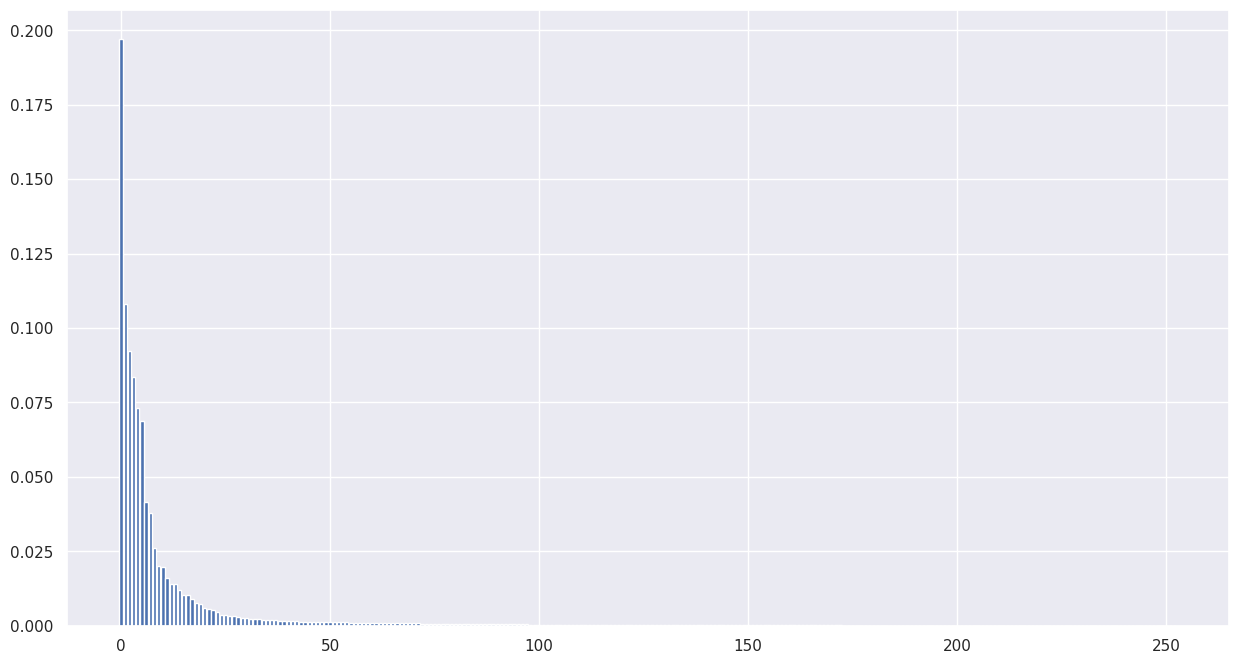

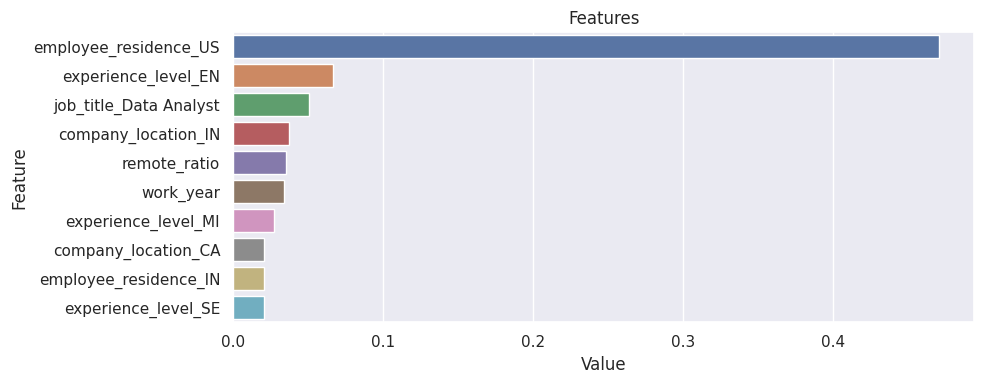

In [160]:
random_forest.plot_PCA()
random_forest.plot_importance(number = 10)

In [161]:
random_forest.customize_x(n_pca_comp = 30)
random_forest.run_model()

The result on the test set r2: 0.563047165066791
The result on the test set MSE: 0.15654023112656887
The result on the test set MAE: 0.29424134768742344


RandomForestRegressor(min_samples_leaf=2, n_estimators=50, random_state=42)

#**MODEL 2 - XGBoost**

In [162]:
xgboost = XGBoost(X_train, Y_train, X_test, Y_test)

In [163]:
xgboost.run_param_grid_search()
xgboost.run_param_random_search()

Total parameters 80
Grid search best result: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100}
Total parameters 80
Random search best result: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)


In [164]:
xgboost.customize_model(max_depth = 8, n_estimators= 100, learning_rate = 0.1)
xg_model = xgboost.run_model(name = 'XGboost')

The result on the test set r2: 0.5855544946355697
The result on the test set MSE: 0.14847688357264568
The result on the test set MAE: 0.285253879592289


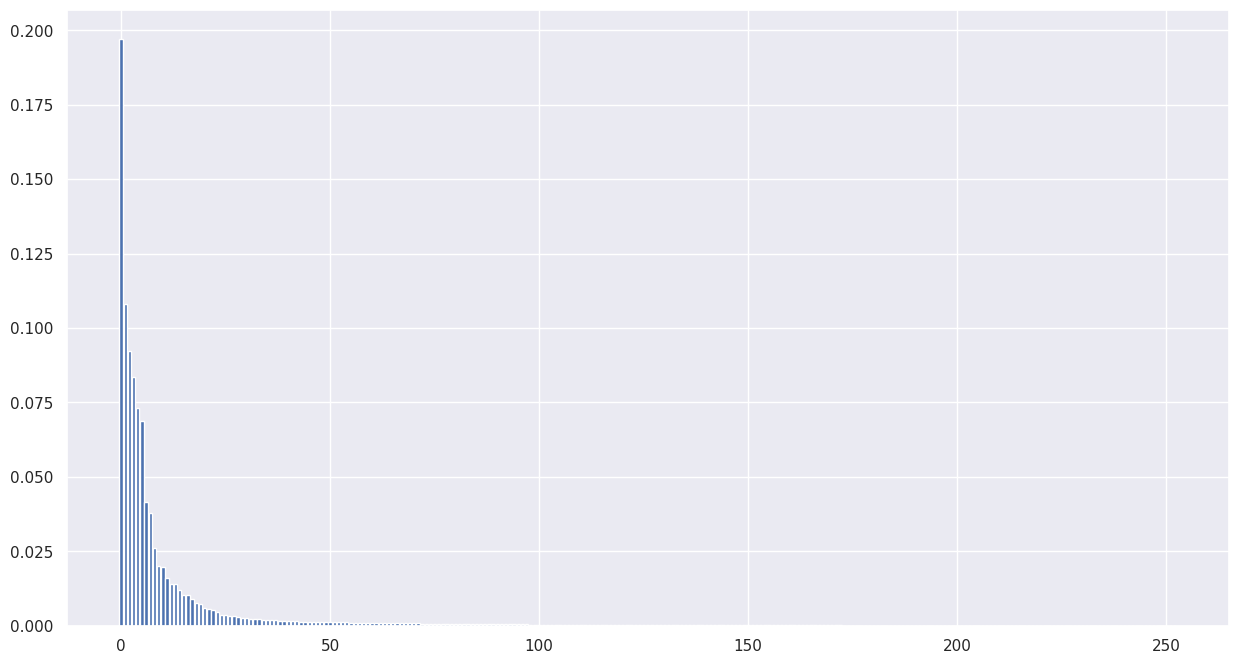

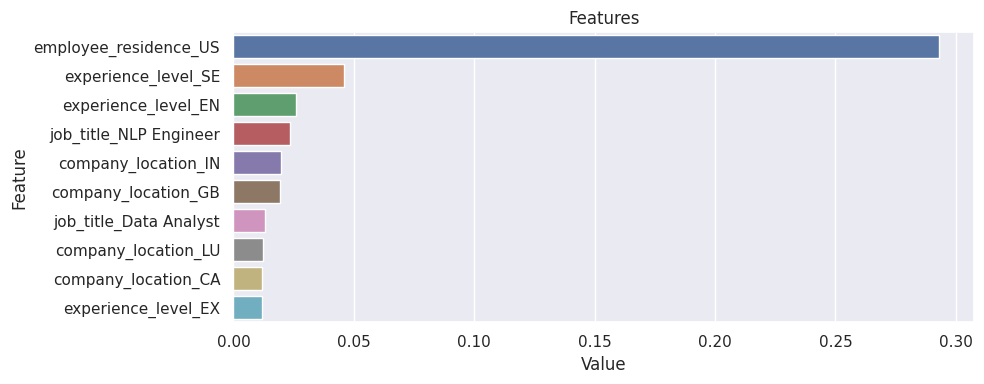

In [165]:
xgboost.plot_PCA()
xgboost.plot_importance(number = 10)

In [166]:
xgboost.customize_x(n_pca_comp = 20)
xgboost.run_model()

The result on the test set r2: 0.553392038977883
The result on the test set MSE: 0.1599992215453971
The result on the test set MAE: 0.29660052441762325


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

#**MODEL 3 - Linear Regression**

In [167]:
linear_regression = Linear(X_train, Y_train, X_test, Y_test)
linear_regression.run_model()

The result on the test set r2: -2.7412633561275535e+22
The result on the test set MSE: 9.820693792102172e+21
The result on the test set MAE: 7390895849.053882


LinearRegression()

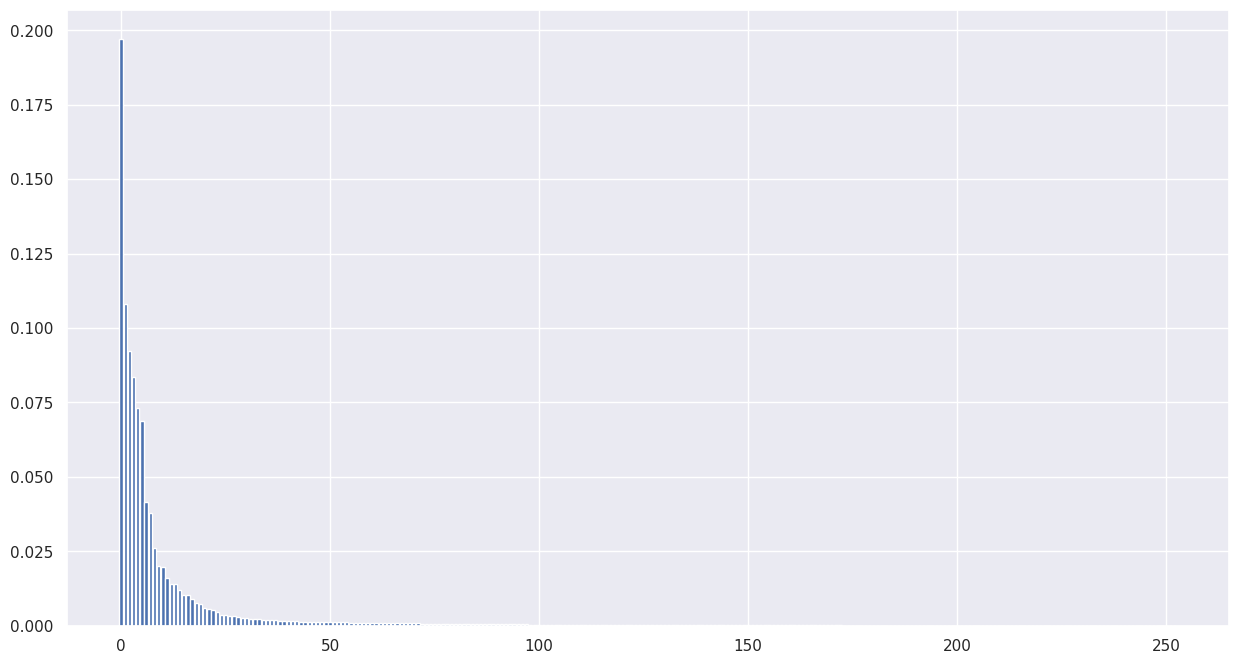

In [168]:
linear_regression.plot_PCA()

In [169]:
linear_regression.customize_x(n_pca_comp = 20)
linear_regression.run_model(name = 'Linear Regression')

The result on the test set r2: 0.5566914850007456
The result on the test set MSE: 0.15881718082677473
The result on the test set MAE: 0.297146078984821


LinearRegression()

#**MODEL 4 - SVR**

In [170]:
svr = SVRModel(X_train, Y_train, X_test, Y_test)

In [171]:
svr.run_param_grid_search()

Total parameters 25
Grid search best result: {'C': 1, 'gamma': 0.1}


In [172]:
svr.customize_model(gamma = 0.1, C= 1)
svr_model = svr.run_model(name = 'SVR')

The result on the test set r2: 0.6003677986917845
The result on the test set MSE: 0.14316995372731708
The result on the test set MAE: 0.28478002246888273


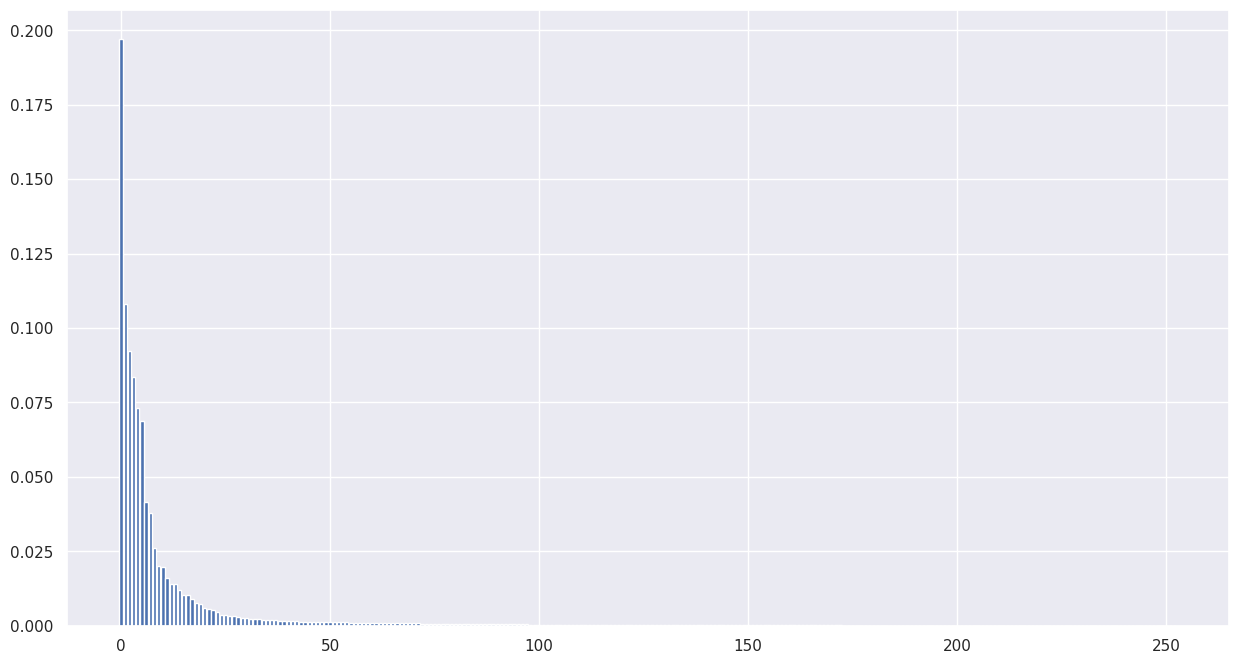

In [173]:
svr.plot_PCA()

In [174]:
svr.customize_x(n_pca_comp = 50)
svr.run_model()

The result on the test set r2: 0.589804917219233
The result on the test set MSE: 0.14695415141384433
The result on the test set MAE: 0.28674570848174524


SVR(C=1, gamma=0.1)

#**MODEL 5 - KNN**

In [175]:
knn = KNN(X_train, Y_train, X_test, Y_test)

In [176]:
knn.run_param_grid_search()

Total parameters 27
Grid search best result: {'metric': 'minkowski', 'n_neighbors': 8}


In [177]:
knn.customize_model(n_neighbors = 8, metric = 'minkowski')
knn.run_model()

The result on the test set r2: 0.5293685098429219
The result on the test set MSE: 0.1686057541104908
The result on the test set MAE: 0.3008636498247254


KNeighborsRegressor(n_neighbors=8)

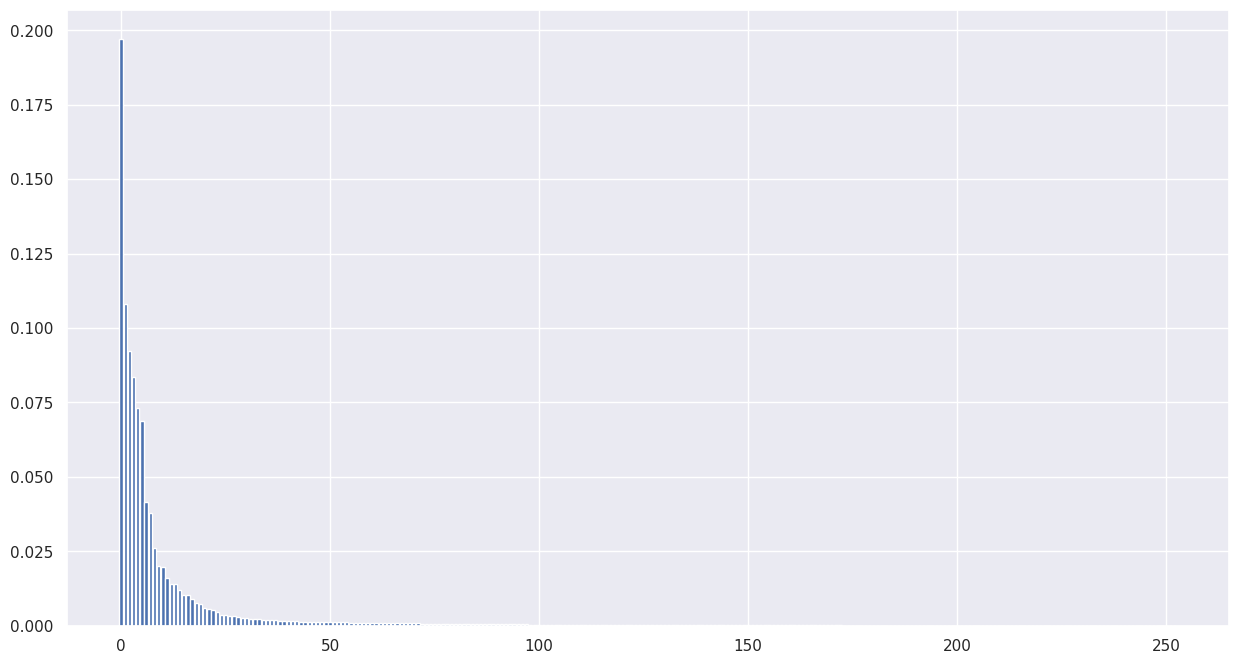

In [178]:
knn.plot_PCA()

In [179]:
knn.customize_x(n_pca_comp = 40)
knn.run_model(name = 'KNN')

The result on the test set r2: 0.5349091565317936
The result on the test set MSE: 0.16662079362064938
The result on the test set MAE: 0.3025529697999377


KNeighborsRegressor(n_neighbors=8)

In [180]:
df_results = pd.DataFrame(Regressor.results)
df_results

,Model_name,R2,MSE,MAE
0,Random Forest,0.578753,0.150913,0.286326
1,XGboost,0.585554,0.148477,0.285254
2,Linear Regression,0.556691,0.158817,0.297146
3,SVR,0.600368,0.143170,0.284780
4,KNN,0.534909,0.166621,0.302553
